In [793]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import os

from keras.src.losses import mean_absolute_error
from prompt_toolkit import history
import tensorflow as tf
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, TensorBoard, ModelCheckpoint

In [660]:
df = pd.read_csv('dataset.csv')
df

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,1.0,2015-02-17 00:19:41,2015-02-17 01:24:48,a914ecef9c12ffdb9bede64bb703d877,fast,4.0,3,1389,3,345,649,17.0,17.0,23.0
197424,1.0,2015-02-13 00:01:59,2015-02-13 00:58:22,a914ecef9c12ffdb9bede64bb703d877,fast,4.0,6,3010,4,405,825,12.0,11.0,14.0
197425,1.0,2015-01-24 04:46:08,2015-01-24 05:36:16,a914ecef9c12ffdb9bede64bb703d877,fast,4.0,5,1836,3,300,399,39.0,41.0,40.0
197426,1.0,2015-02-01 18:18:15,2015-02-01 19:23:22,c81e155d85dae5430a8cee6f2242e82c,sandwich,1.0,1,1175,1,535,535,7.0,7.0,12.0


In [661]:
df.shape

(197428, 14)

In [662]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 196441 non-null  float64
 1   created_at                197428 non-null  object 
 2   actual_delivery_time      197421 non-null  object 
 3   store_id                  197428 non-null  object 
 4   store_primary_category    192668 non-null  object 
 5   order_protocol            196433 non-null  float64
 6   total_items               197428 non-null  int64  
 7   subtotal                  197428 non-null  int64  
 8   num_distinct_items        197428 non-null  int64  
 9   min_item_price            197428 non-null  int64  
 10  max_item_price            197428 non-null  int64  
 11  total_onshift_partners    181166 non-null  float64
 12  total_busy_partners       181166 non-null  float64
 13  total_outstanding_orders  181166 non-null  f

In [663]:
df['store_primary_category'].value_counts()

store_primary_category
american             19399
pizza                17321
mexican              17099
burger               10958
sandwich             10060
                     ...  
lebanese                 9
belgian                  2
indonesian               2
chocolate                1
alcohol-plus-food        1
Name: count, Length: 74, dtype: int64

In [664]:
df['created_at'].isna().sum(), df['actual_delivery_time'].isna().sum()

(np.int64(0), np.int64(7))

In [665]:
# Converting date columns to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   market_id                 196441 non-null  float64       
 1   created_at                197428 non-null  datetime64[ns]
 2   actual_delivery_time      197421 non-null  datetime64[ns]
 3   store_id                  197428 non-null  object        
 4   store_primary_category    192668 non-null  object        
 5   order_protocol            196433 non-null  float64       
 6   total_items               197428 non-null  int64         
 7   subtotal                  197428 non-null  int64         
 8   num_distinct_items        197428 non-null  int64         
 9   min_item_price            197428 non-null  int64         
 10  max_item_price            197428 non-null  int64         
 11  total_onshift_partners    181166 non-null  float64       
 12  to

In [666]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0


In [667]:
# Creating a column with the delivery time of the order
df['time_taken'] = df['actual_delivery_time'] - df['created_at']
df['time_taken'] = df['time_taken'].dt.total_seconds() / 60
df['time_taken'] = np.round(df['time_taken'])
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,time_taken
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,63.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,67.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,30.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,51.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,40.0


In [668]:
df['day_of_week'] = df['created_at'].dt.day_of_week
df['year_o'] = df['created_at'].dt.year.astype('int64')
df['month_o'] = df['created_at'].dt.month.astype('int64')
df['day_o'] =   df['created_at'].dt.day.astype('int64')
df['hour_o'] = df['created_at'].dt.hour.astype('int64')
df['minute_o'] = df['created_at'].dt.minute.astype('int64')
df['second_o'] = df['created_at'].dt.second.astype('int64')

In [669]:
df = df.dropna(subset = ['actual_delivery_time'])

In [670]:
df['year_d'] = df['actual_delivery_time'].dt.year.astype('int64')
df['month_d'] = df['actual_delivery_time'].dt.month.astype('int64')
df['day_d'] =   df['actual_delivery_time'].dt.day.astype('int64')
df['hour_d'] =   df['actual_delivery_time'].dt.hour.astype('int64')
df['minute_d'] = df['actual_delivery_time'].dt.minute.astype('int64')
df['second_d'] = df['actual_delivery_time'].dt.second.astype('int64')
df['day_of_week_d'] = df['actual_delivery_time'].dt.day_of_week

In [671]:
# Dropping the date columns as we have extracted the required info.
df.drop(['created_at', 'actual_delivery_time'], axis=1, inplace=True)
df.head()

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,...,hour_o,minute_o,second_o,year_d,month_d,day_d,hour_d,minute_d,second_d,day_of_week_d
0,1.0,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,...,22,24,17,2015,2,6,23,27,16,4
1,2.0,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,...,21,49,25,2015,2,10,22,56,29,1
2,3.0,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,...,20,39,28,2015,1,22,21,9,9,3
3,3.0,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,...,21,21,45,2015,2,3,22,13,0,1
4,3.0,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,...,2,40,36,2015,2,15,3,20,26,6


#### Dealing with null values.

In [672]:
df['store_primary_category'] = df['store_primary_category'].fillna(df['store_primary_category'].mode()[0])
df['total_onshift_partners'] =  df['total_onshift_partners'].fillna(df['total_onshift_partners'].median())
df['total_busy_partners'] =  df['total_busy_partners'].fillna(df['total_busy_partners'].median())
df['total_outstanding_orders'] =  df['total_outstanding_orders'].fillna(df['total_outstanding_orders'].median())
df['market_id'] = df['market_id'].fillna(df['market_id'].mode()[0])
df['order_protocol'] = df['order_protocol'].fillna(df['order_protocol'].mode()[0])

In [673]:
df['time_taken'].isna().sum()

np.int64(0)

In [674]:
df = df[~df['time_taken'].isna()]

In [675]:
df['time_taken'].isna().sum()

np.int64(0)

In [676]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197421 entries, 0 to 197427
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 197421 non-null  float64
 1   store_id                  197421 non-null  object 
 2   store_primary_category    197421 non-null  object 
 3   order_protocol            197421 non-null  float64
 4   total_items               197421 non-null  int64  
 5   subtotal                  197421 non-null  int64  
 6   num_distinct_items        197421 non-null  int64  
 7   min_item_price            197421 non-null  int64  
 8   max_item_price            197421 non-null  int64  
 9   total_onshift_partners    197421 non-null  float64
 10  total_busy_partners       197421 non-null  float64
 11  total_outstanding_orders  197421 non-null  float64
 12  time_taken                197421 non-null  float64
 13  day_of_week               197421 non-null  int32 

In [677]:
df.drop('store_id', axis=1, inplace=True)
df.head()

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,...,hour_o,minute_o,second_o,year_d,month_d,day_d,hour_d,minute_d,second_d,day_of_week_d
0,1.0,american,1.0,4,3441,4,557,1239,33.0,14.0,...,22,24,17,2015,2,6,23,27,16,4
1,2.0,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,...,21,49,25,2015,2,10,22,56,29,1
2,3.0,american,1.0,1,1900,1,1900,1900,1.0,0.0,...,20,39,28,2015,1,22,21,9,9,3
3,3.0,american,1.0,6,6900,5,600,1800,1.0,1.0,...,21,21,45,2015,2,3,22,13,0,1
4,3.0,american,1.0,3,3900,3,1100,1600,6.0,6.0,...,2,40,36,2015,2,15,3,20,26,6


In [678]:
df.isna().sum()

market_id                   0
store_primary_category      0
order_protocol              0
total_items                 0
subtotal                    0
num_distinct_items          0
min_item_price              0
max_item_price              0
total_onshift_partners      0
total_busy_partners         0
total_outstanding_orders    0
time_taken                  0
day_of_week                 0
year_o                      0
month_o                     0
day_o                       0
hour_o                      0
minute_o                    0
second_o                    0
year_d                      0
month_d                     0
day_d                       0
hour_d                      0
minute_d                    0
second_d                    0
day_of_week_d               0
dtype: int64

In [679]:
df.shape

(197421, 26)

In [680]:
df.head()

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,...,hour_o,minute_o,second_o,year_d,month_d,day_d,hour_d,minute_d,second_d,day_of_week_d
0,1.0,american,1.0,4,3441,4,557,1239,33.0,14.0,...,22,24,17,2015,2,6,23,27,16,4
1,2.0,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,...,21,49,25,2015,2,10,22,56,29,1
2,3.0,american,1.0,1,1900,1,1900,1900,1.0,0.0,...,20,39,28,2015,1,22,21,9,9,3
3,3.0,american,1.0,6,6900,5,600,1800,1.0,1.0,...,21,21,45,2015,2,3,22,13,0,1
4,3.0,american,1.0,3,3900,3,1100,1600,6.0,6.0,...,2,40,36,2015,2,15,3,20,26,6


#### Exploratory Data Analysis

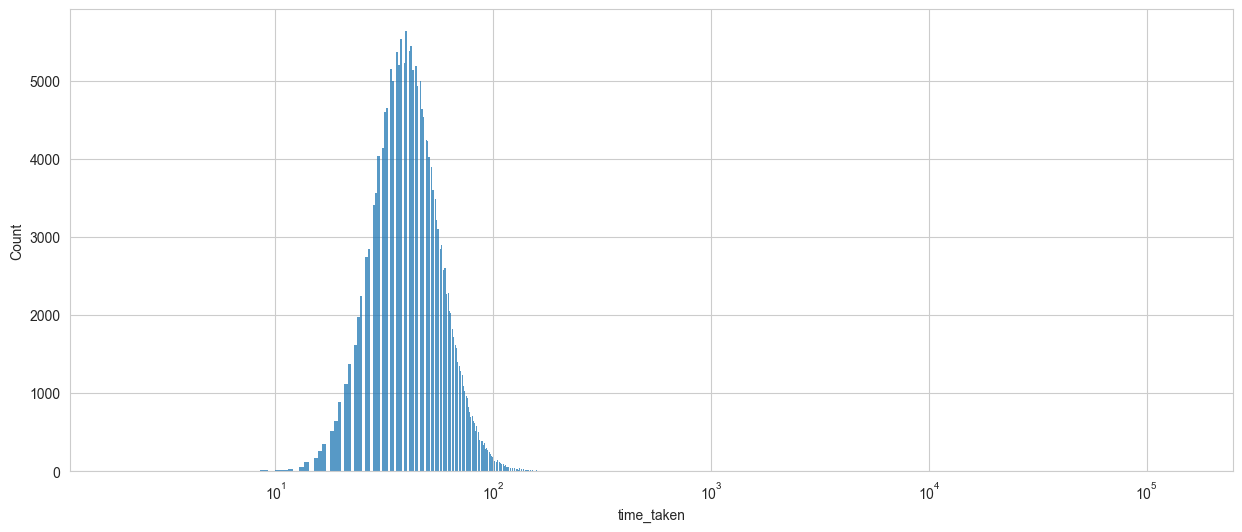

In [681]:
plt.figure(figsize=(15, 6))
sns.set_style('whitegrid')
sns.histplot(df['time_taken'])
plt.xscale('log')
plt.show()

##### Most of the orders take around 10 t 100 minutes to deliver.

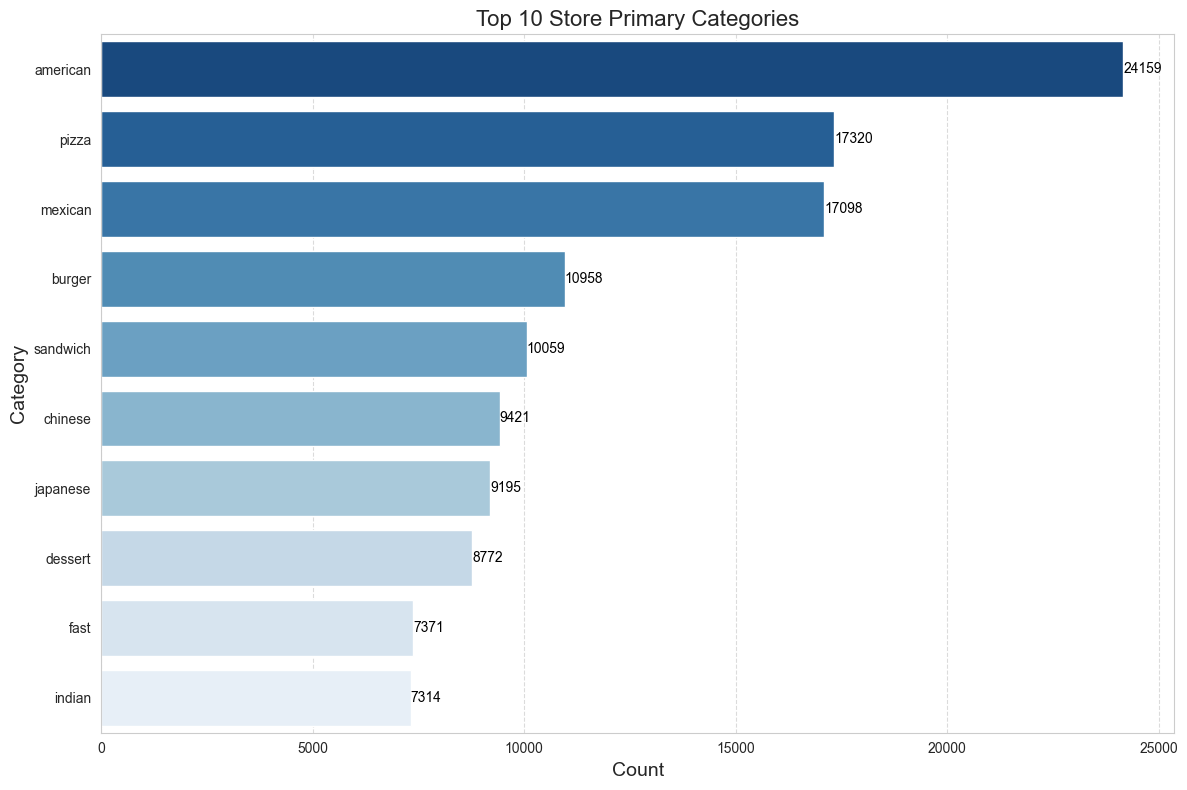

In [682]:
plt.figure(figsize=(12, 8))

top_categories = df['store_primary_category'].value_counts().nlargest(10)
sns.barplot(
    x=top_categories.values,
    y=top_categories.index,
    palette='Blues_r'
)

for i, v in enumerate(top_categories.values):
    plt.text(v + 5, i, str(v), va='center', fontsize=10, color='black')

plt.title('Top 10 Store Primary Categories', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

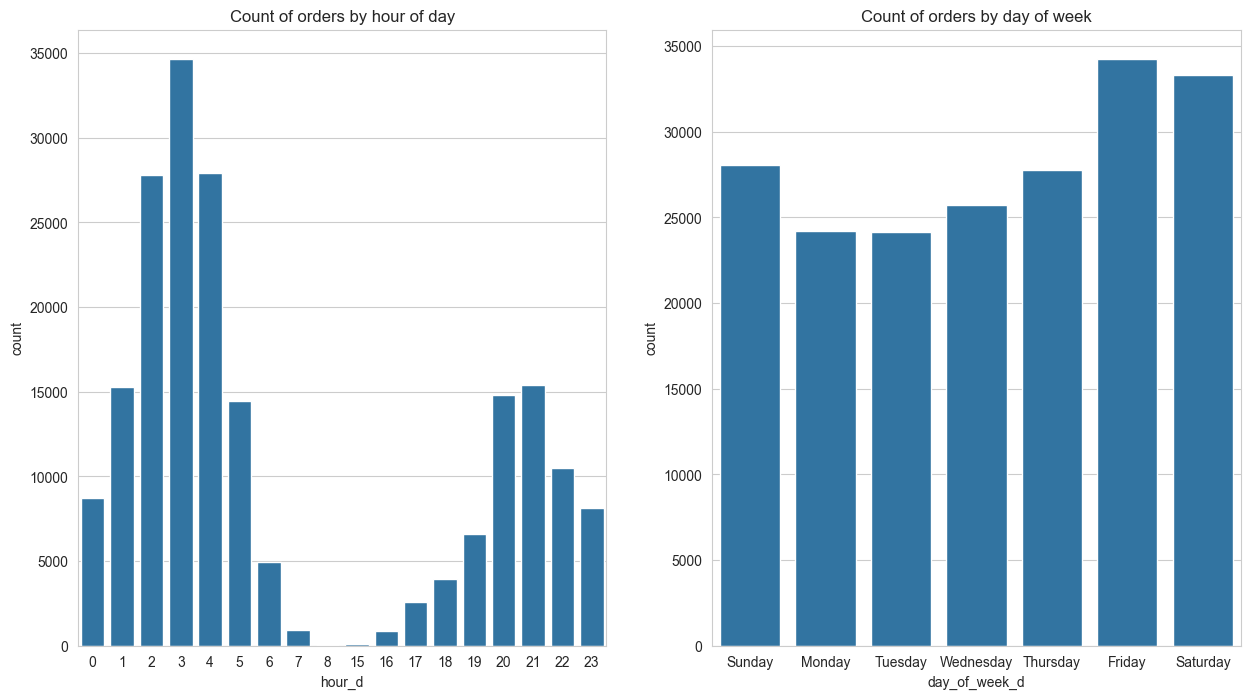

In [683]:
fig, ax = plt.subplots(figsize=(15, 8), nrows=1, ncols=2)
sns.countplot(data=df, x='hour_d', ax=ax[0])
sns.countplot(data=df, x='day_of_week_d', ax=ax[1])
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
ax[1].set_xticks(range(7))
ax[1].set_xticklabels(days)

ax[0].set_title('Count of orders by hour of day')
ax[1].set_title('Count of orders by day of week')
plt.show()

##### We notice a high frequency of orders at hours 2, 3, 4 peaking at 3. We can deploy more resources at these hours to cater to the demand.
##### Friday, Saturday and Sunday observe the most number of orders.

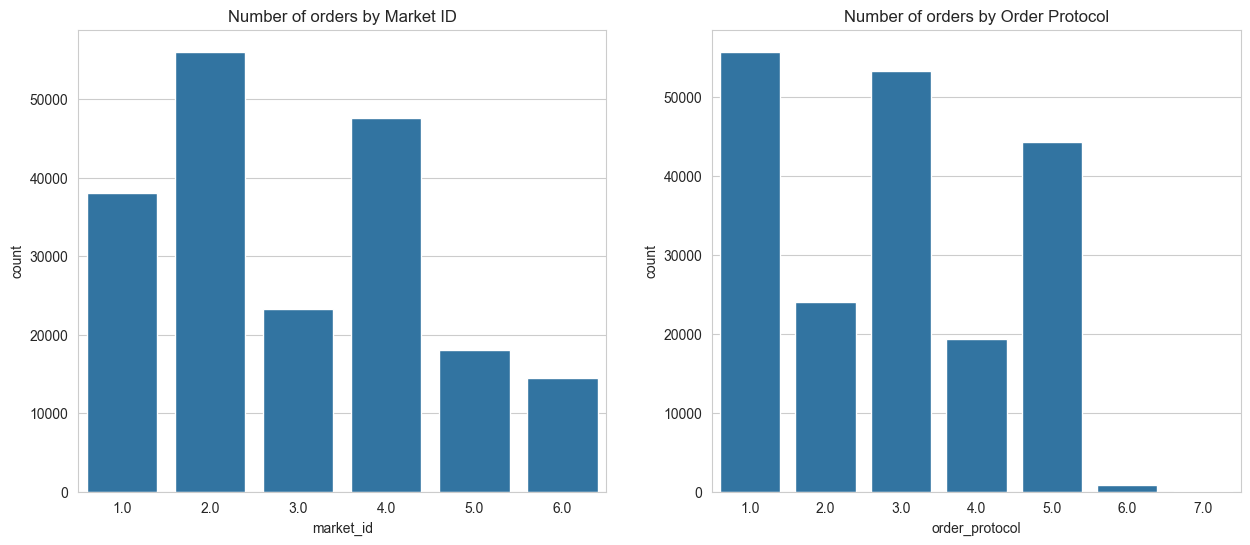

In [684]:
fig2, ax = plt.subplots(figsize=(15,6), nrows=1, ncols=2)

sns.countplot(data=df, x='market_id', ax=ax[0])
ax[0].set_title('Number of orders by Market ID')

sns.countplot(data=df, x='order_protocol', ax=ax[1])
ax[1].set_title('Number of orders by Order Protocol')

plt.show()

##### Market ID 2 receives the most number of orders followed by 4.
##### Order delivery method(order_protocol) are the most popular.

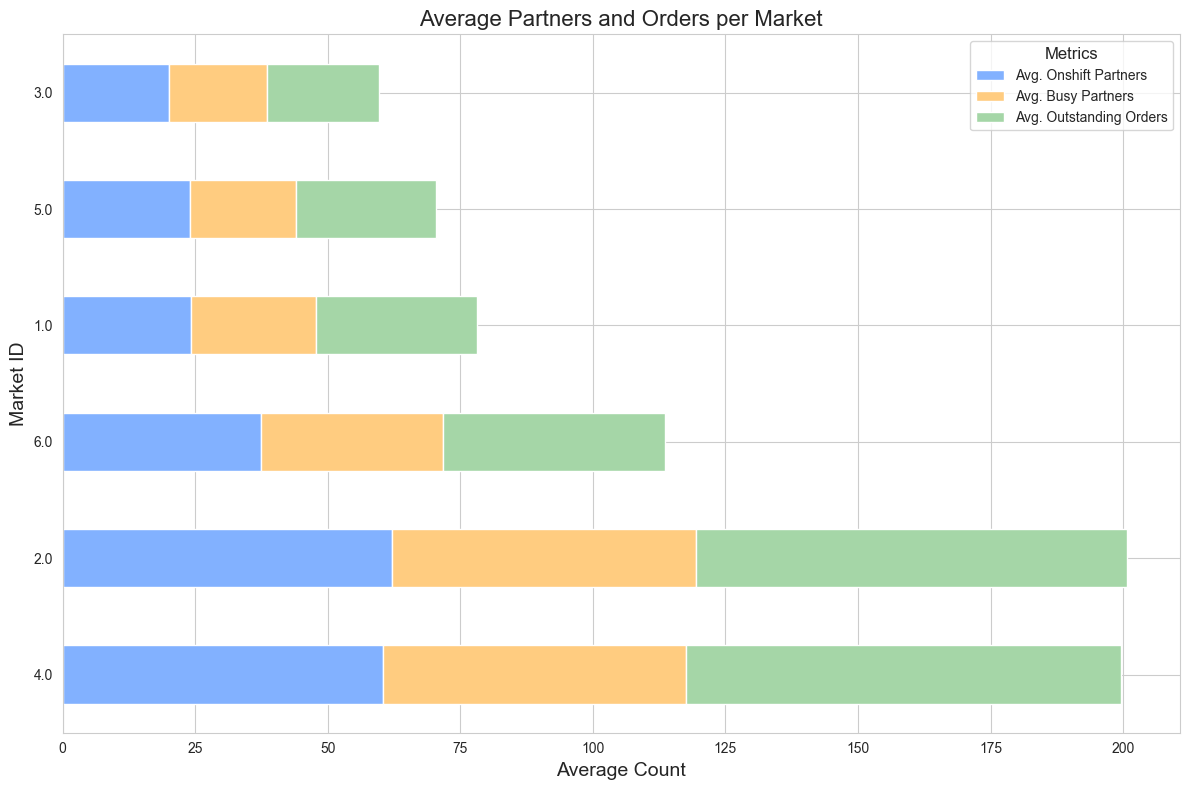

In [685]:
avg_data_market = pd.DataFrame({
    'Avg. Onshift Partners': df.groupby('market_id')['total_onshift_partners'].mean(),
    'Avg. Busy Partners': df.groupby('market_id')['total_busy_partners'].mean(),
    'Avg. Outstanding Orders': df.groupby('market_id')['total_outstanding_orders'].mean()
}).sort_values('Avg. Outstanding Orders', ascending=False)

avg_data_market.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 8),
    color=['#82b1ff', '#ffcc80', '#a5d6a7']
)

plt.title('Average Partners and Orders per Market', fontsize=16)
plt.xlabel('Average Count', fontsize=14)
plt.ylabel('Market ID', fontsize=14)
plt.legend(title='Metrics', fontsize=10, title_fontsize=12)
plt.tight_layout()

plt.show()

##### We can see the Market ID 2 and 4 have the maximum partners and orders.

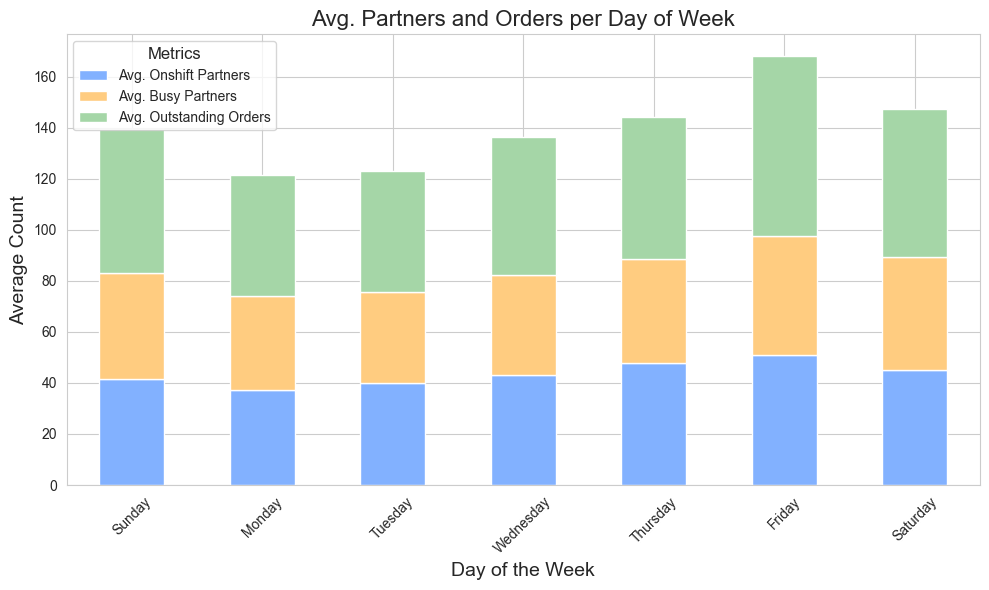

In [686]:
avg_data = pd.DataFrame({
    'Avg. Onshift Partners': df.groupby('day_of_week_d')['total_onshift_partners'].mean(),
    'Avg. Busy Partners': df.groupby('day_of_week_d')['total_busy_partners'].mean(),
    'Avg. Outstanding Orders': df.groupby('day_of_week_d')['total_outstanding_orders'].mean()
})

avg_data.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#82b1ff', '#ffcc80', '#a5d6a7']
)

plt.title('Avg. Partners and Orders per Day of Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Average Count', fontsize=14)
plt.xticks(ticks=range(7), labels=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
plt.legend(title='Metrics', fontsize=10, title_fontsize=12)
plt.tight_layout()

plt.show()

##### The graph above gives a clear picture of partner availability and outstanding orders on each day in a week.
##### Clearly Friday's have the most number of available partners.

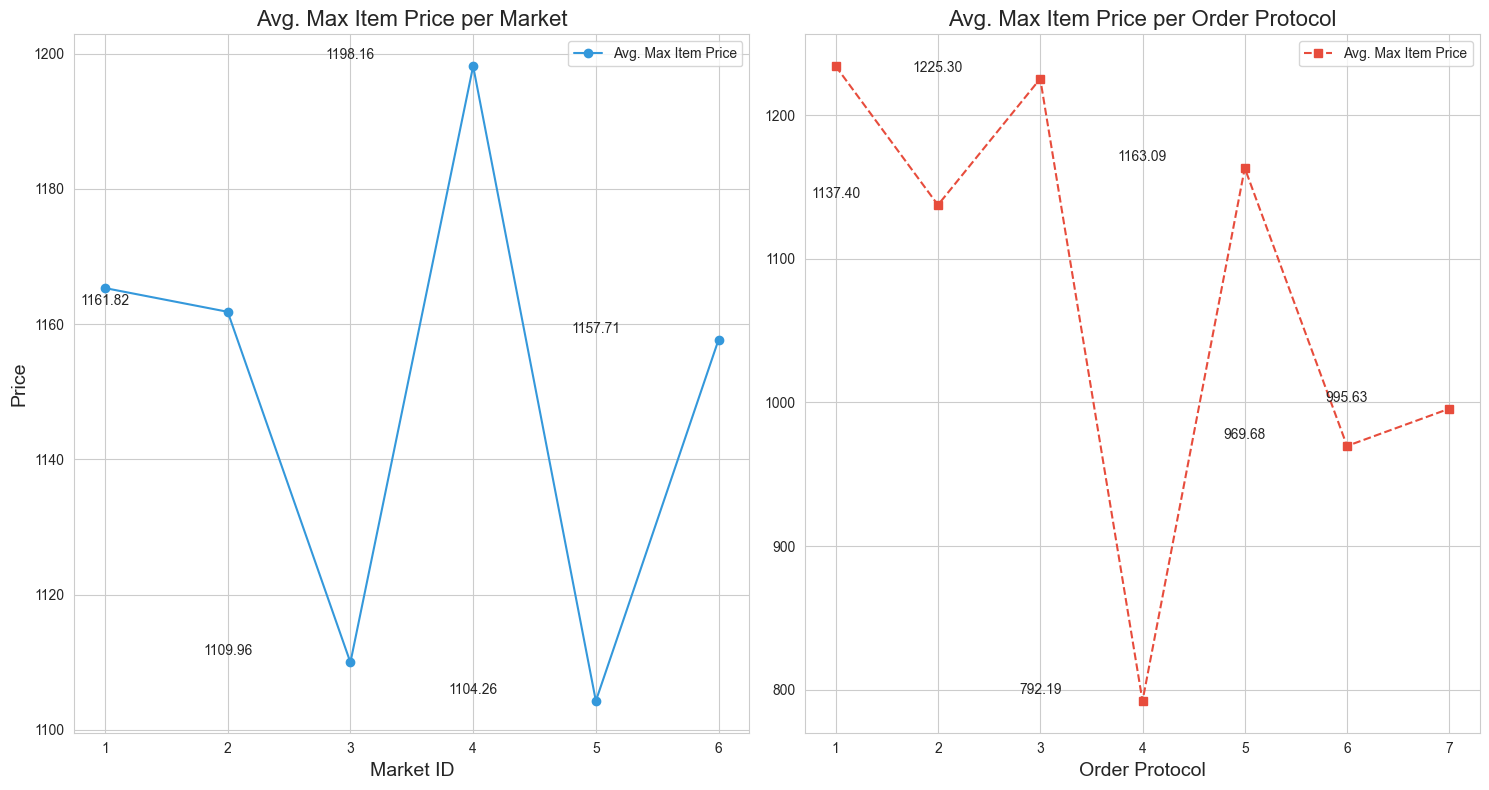

In [687]:
fig5, ax = plt.subplots(figsize=(15, 8), nrows=1, ncols=2)

market_data = df.groupby('market_id')['max_item_price'].mean().sort_index()
ax[0].plot(
    market_data,
    marker='o',
    linestyle='-',
    color='#3498db',
    label='Avg. Max Item Price'
)
ax[0].set_title('Avg. Max Item Price per Market', fontsize=16)
ax[0].set_xlabel('Market ID', fontsize=14)
ax[0].set_ylabel('Price', fontsize=14)
ax[0].grid(True)
ax[0].legend()

for i, value in enumerate(market_data):
    ax[0].annotate(f'{value:.2f}', (i, value), textcoords="offset points", xytext=(0, 5), ha='center')

protocol_data = df.groupby('order_protocol')['max_item_price'].mean().sort_index()
ax[1].plot(
    protocol_data,
    marker='s',
    linestyle='--',
    color='#e74c3c',
    label='Avg. Max Item Price'
)
ax[1].set_title('Avg. Max Item Price per Order Protocol', fontsize=16)
ax[1].set_xlabel('Order Protocol', fontsize=14)
ax[1].grid(True)
ax[1].legend()

for i, value in enumerate(protocol_data):
    ax[1].annotate(f'{value:.2f}', (i, value), textcoords="offset points", xytext=(0, 5), ha='center')

plt.tight_layout()
plt.show()

##### Market ID 4 receives orders with maximum value, we can capitalise on it by deploying more resources here.
##### Order Protocol (or Delivery method) 1 contains the maximum value by price, indication that valuable items are preferred to be sent by this method.

In [688]:
df_3 = df.groupby('day_of_week_d').agg({'time_taken': 'mean', 'subtotal': 'mean'}).reset_index()
df_3

,day_of_week_d,time_taken,subtotal
0,0,51.468550,2720.609619
1,1,46.467769,2578.353223
2,2,44.147262,2590.673648
3,3,47.339430,2595.263543
4,4,44.751063,2616.851495
5,5,50.113749,2801.565677
6,6,52.816854,2791.151017


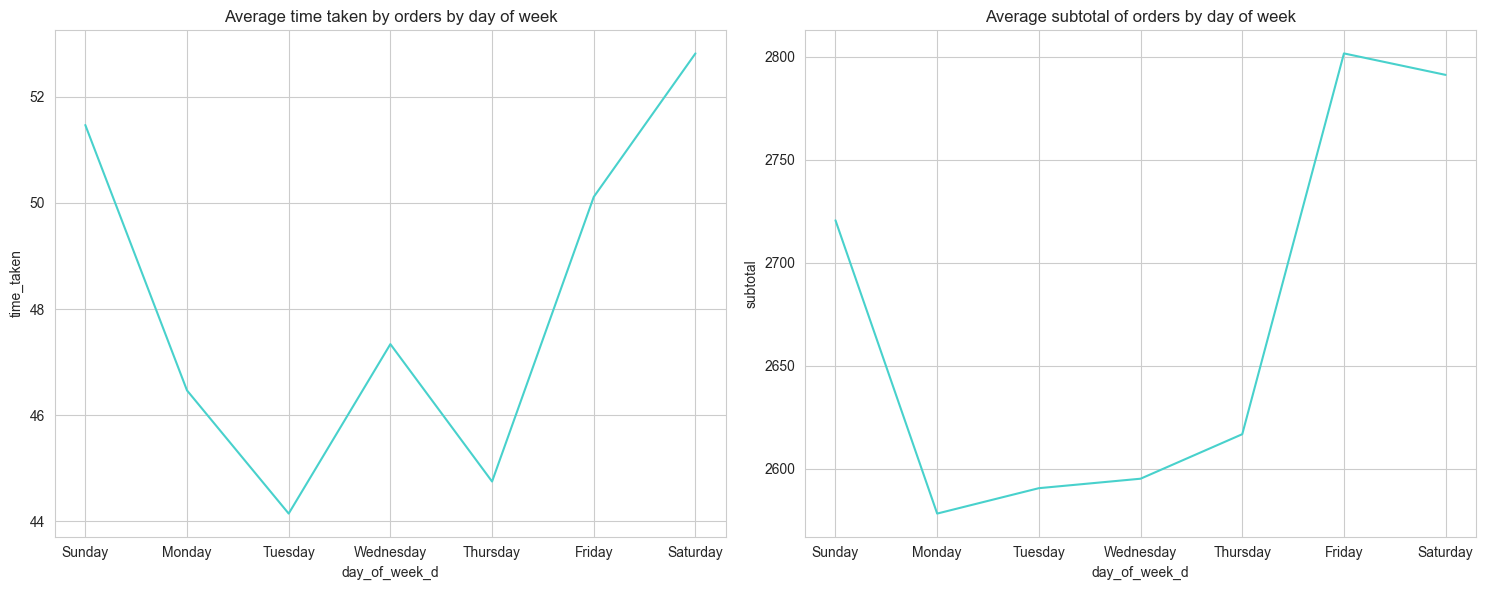

In [689]:
plt.figure(figsize = (15,6))
sns.set_style("whitegrid")
palette = sns.color_palette("Paired")
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

plt.subplot(1,2,1)
sns.lineplot(data = df_3, x = 'day_of_week_d', y = 'time_taken', color = 'mediumturquoise')
ax = plt.gca()
ax.set_xticks(range(7))
ax.set_xticklabels(days)
ax.set_title('Average time taken by orders by day of week')

plt.subplot(1,2,2)
sns.lineplot(data = df_3, x = 'day_of_week_d', y = 'subtotal', color = 'mediumturquoise')
ax = plt.gca()
ax.set_xticks(range(7))
ax.set_xticklabels(days)
ax.set_title('Average subtotal of orders by day of week')

plt.tight_layout()
plt.show()

##### Max delivery time peaks on the weekends.
##### Consequently average order values('subtotal') are also higher on the weekends.

Text(0.5, 1.0, 'Correlation Matrix')

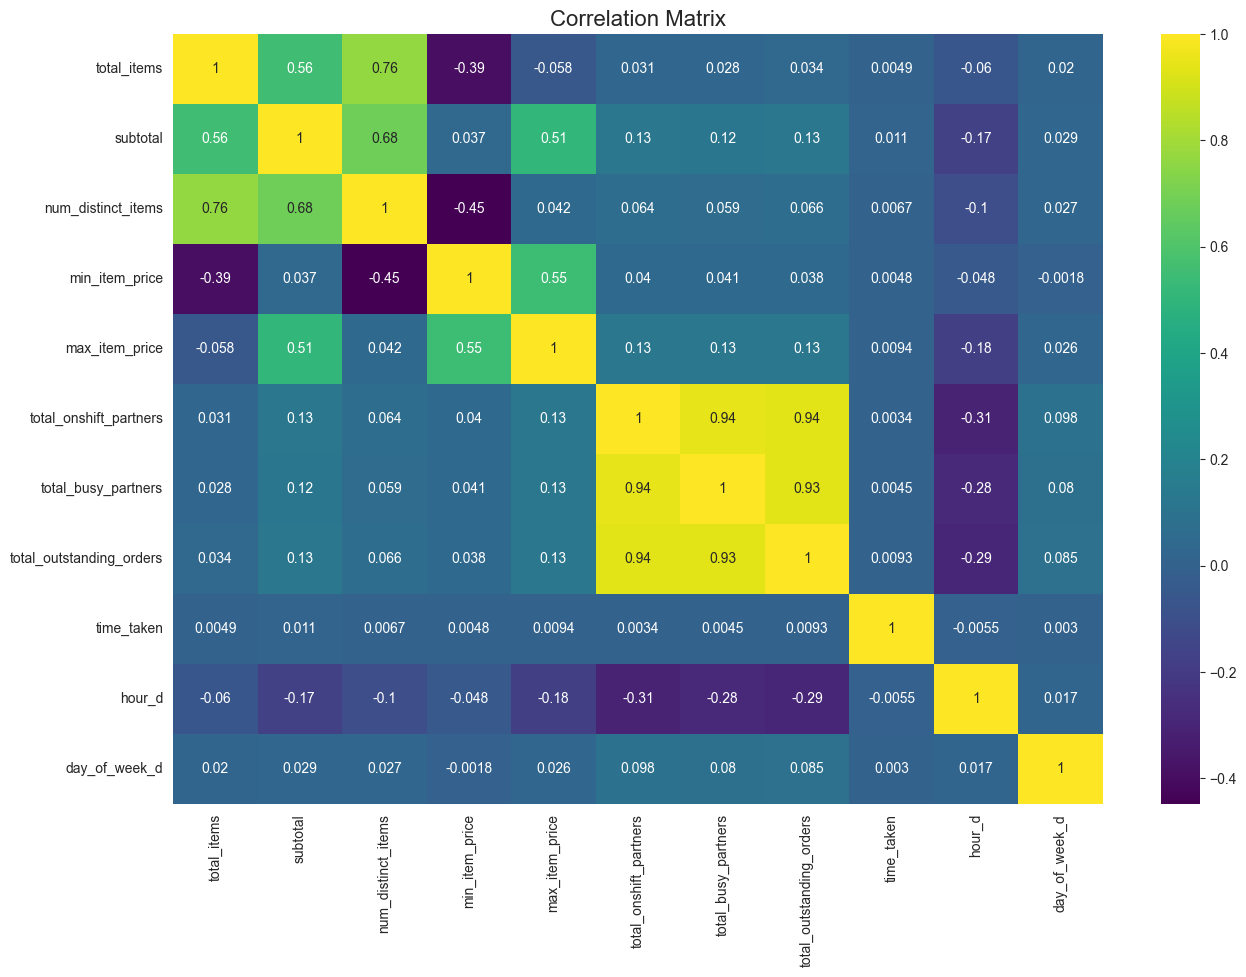

In [690]:
df_corr = df.drop(['market_id','store_primary_category','order_protocol','day_of_week','year_o','month_o','day_o','hour_o','minute_o','second_o','year_d','month_d','day_d','minute_d','second_d'],axis =1).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(df_corr, annot=True, cmap='viridis')
plt.title('Correlation Matrix', fontsize=16)

##### We can see above that attributes, 'total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders', have a significantly high correlation(0.94).
##### We drop 'total_busy_partners' and 'total_outstanding_orders' one by one to see the effect of the correlation matrix.

Text(0.5, 1.0, 'Correlation Matrix')

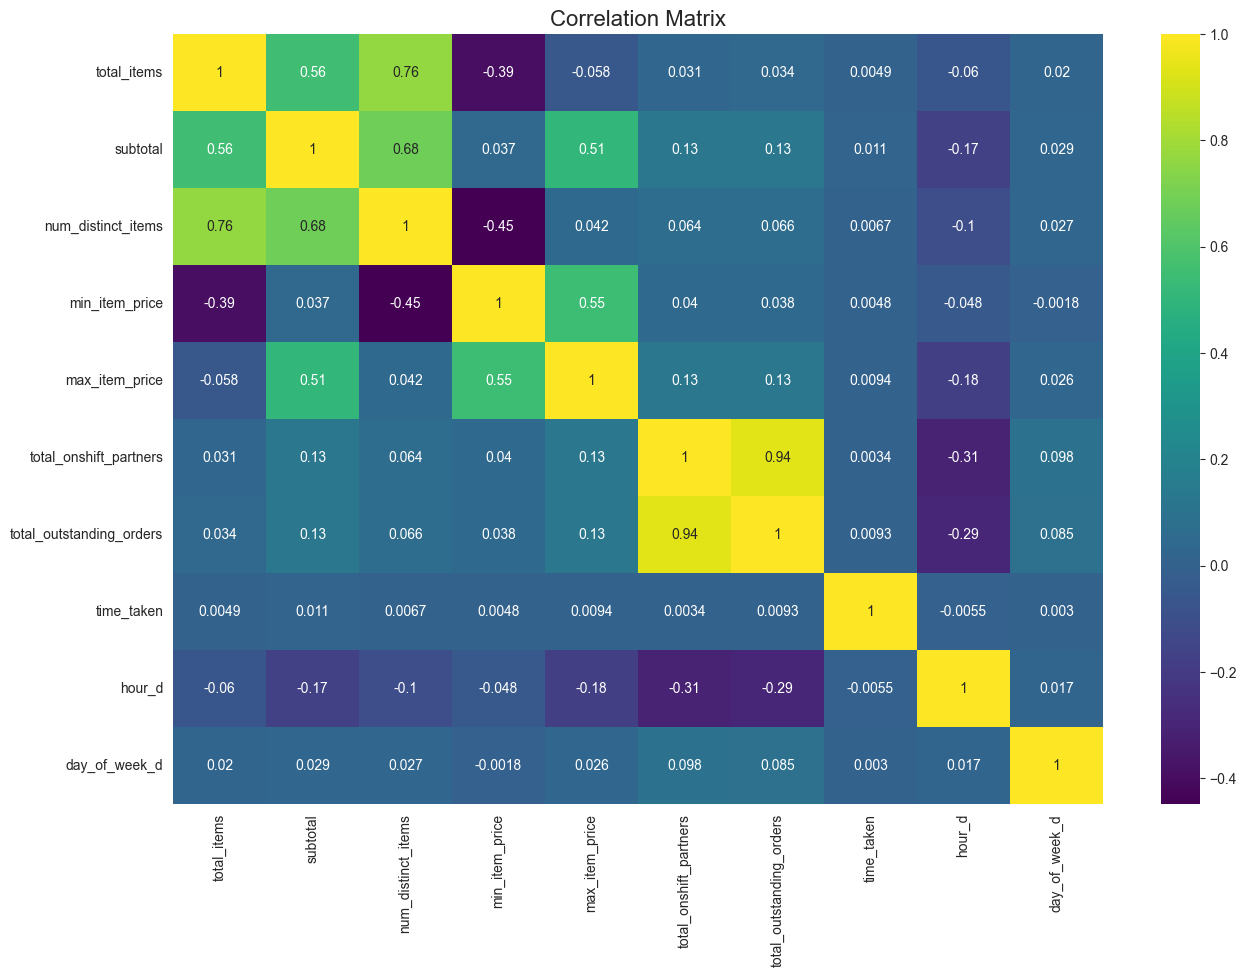

In [691]:
df_corr = df.drop(['market_id','store_primary_category','order_protocol','day_of_week','year_o','month_o','day_o','hour_o','minute_o','second_o','year_d','month_d','day_d','minute_d','second_d', 'total_busy_partners'], axis=1).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(df_corr, annot=True, cmap='viridis')
plt.title('Correlation Matrix', fontsize=16)

##### We still see a high correlation, so we drop 'total_outstanding_orders' as well, as this might affect our model performance.

Text(0.5, 1.0, 'Correlation Matrix')

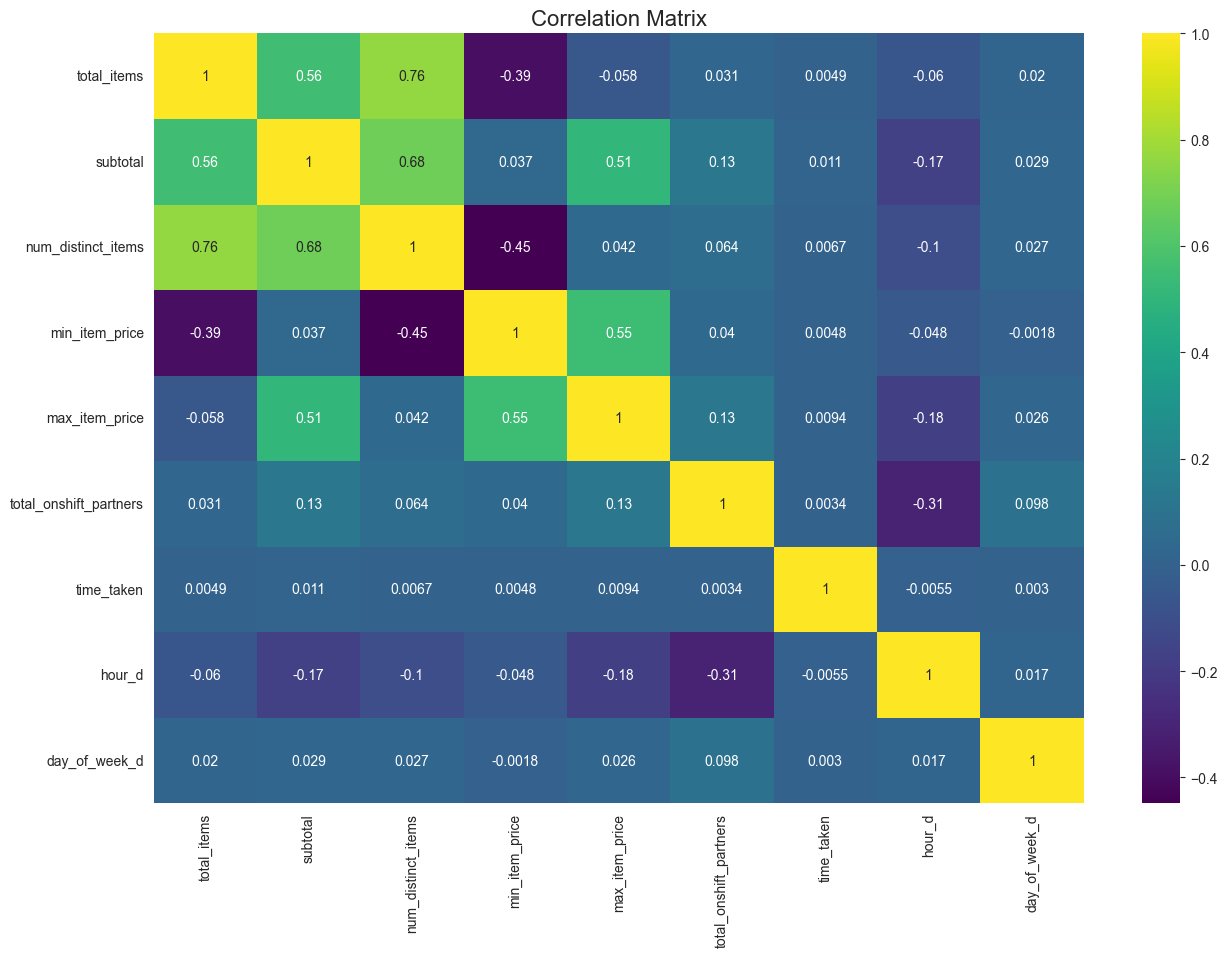

In [692]:
df_corr = df.drop(['market_id','store_primary_category','order_protocol','day_of_week','year_o','month_o','day_o','hour_o','minute_o','second_o','year_d','month_d','day_d','minute_d','second_d', 'total_busy_partners', 'total_outstanding_orders'], axis=1).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(df_corr, annot=True, cmap='viridis')
plt.title('Correlation Matrix', fontsize=16)

##### After dropping the attributes, we do not see any highly correlated features, so we permanently drop those features.

In [693]:
df.drop(['total_busy_partners', 'total_outstanding_orders'], axis=1, inplace=True)
df.head()

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,time_taken,...,hour_o,minute_o,second_o,year_d,month_d,day_d,hour_d,minute_d,second_d,day_of_week_d
0,1.0,american,1.0,4,3441,4,557,1239,33.0,63.0,...,22,24,17,2015,2,6,23,27,16,4
1,2.0,mexican,2.0,1,1900,1,1400,1400,1.0,67.0,...,21,49,25,2015,2,10,22,56,29,1
2,3.0,american,1.0,1,1900,1,1900,1900,1.0,30.0,...,20,39,28,2015,1,22,21,9,9,3
3,3.0,american,1.0,6,6900,5,600,1800,1.0,51.0,...,21,21,45,2015,2,3,22,13,0,1
4,3.0,american,1.0,3,3900,3,1100,1600,6.0,40.0,...,2,40,36,2015,2,15,3,20,26,6


#### Outlier Treatment

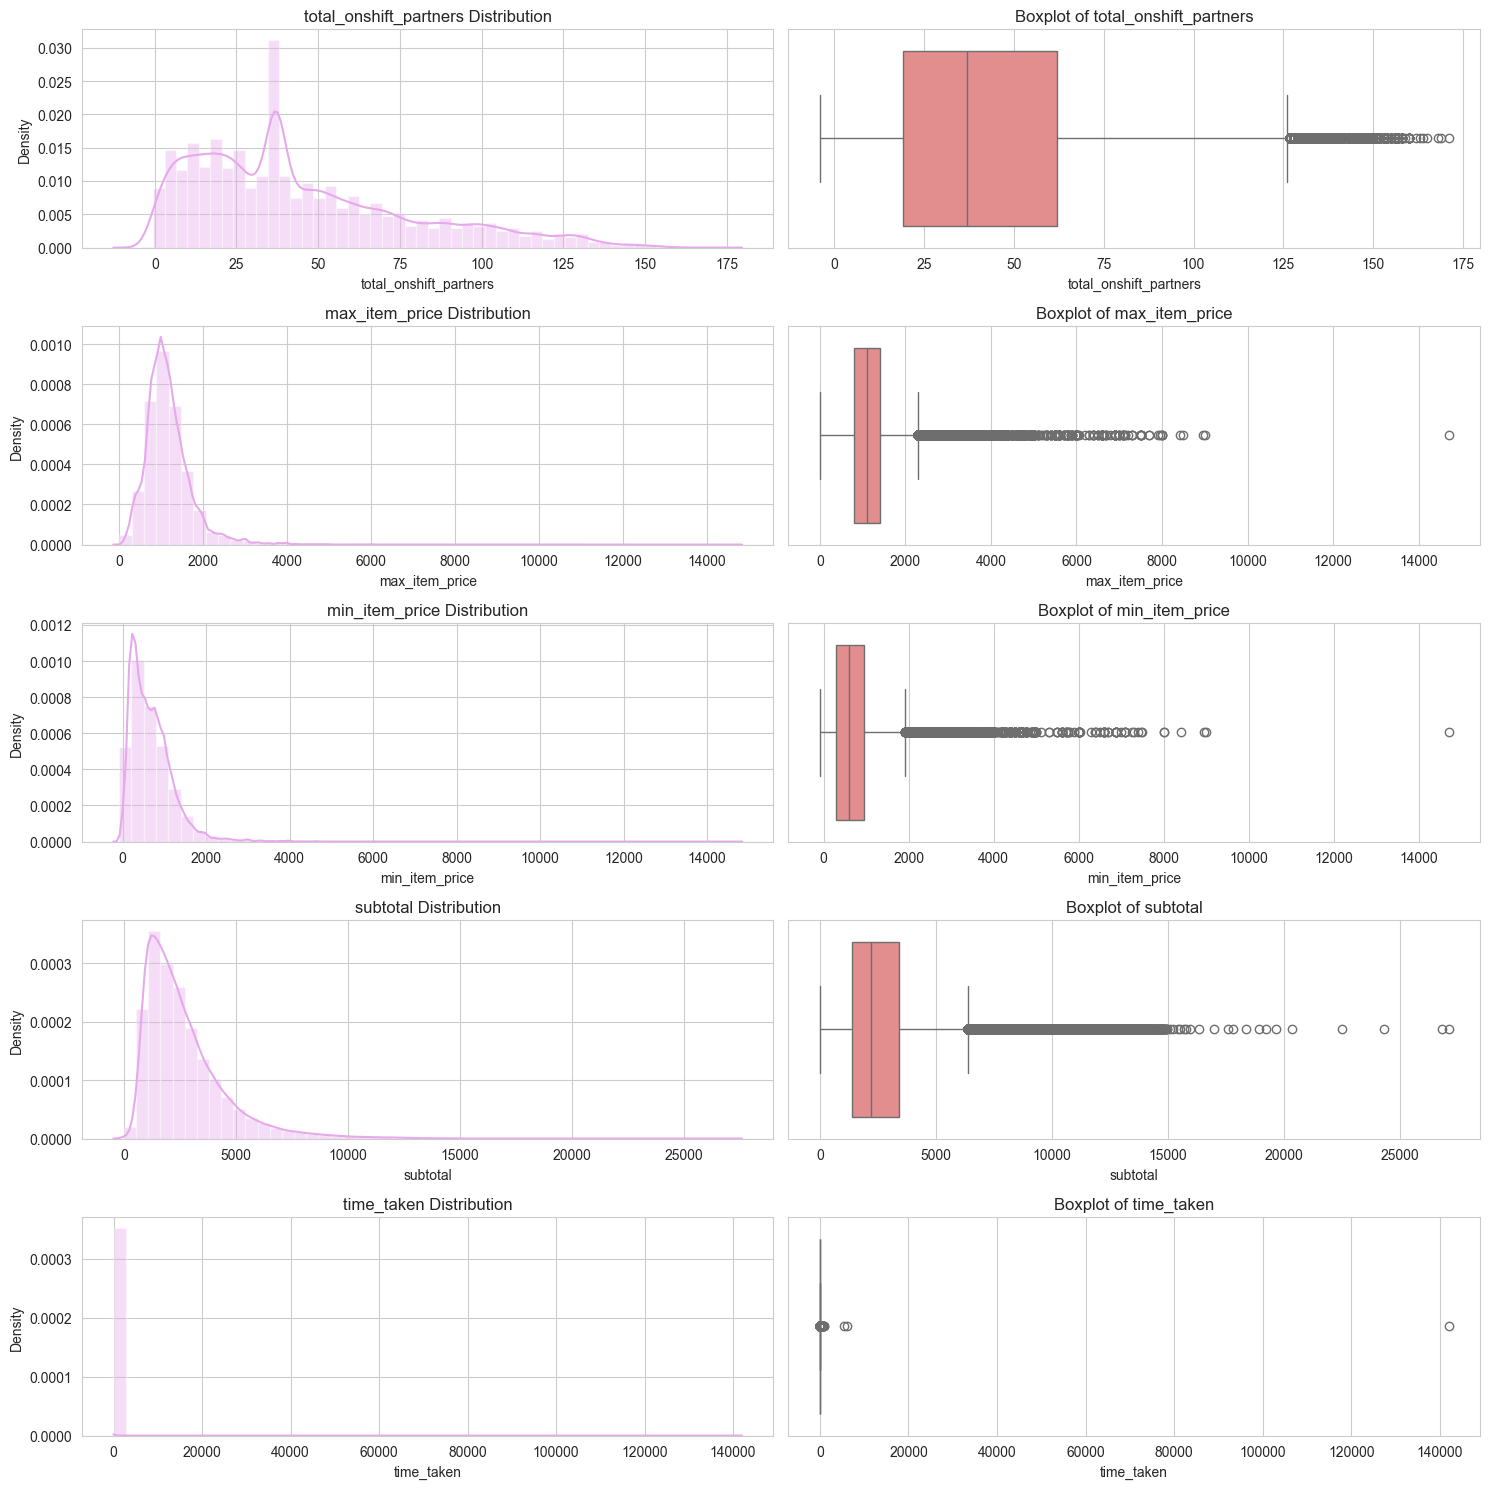

In [694]:
num_cols = ['total_onshift_partners', 'max_item_price','min_item_price', 'subtotal', 'time_taken']

fig6, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

for i, col in enumerate(num_cols):
    sns.distplot(df[col], ax=ax[i, 0], color='#E6A9EC')
    sns.boxplot(data=df, x=df[col], ax=ax[i, 1], color='#F08080')
    ax[i, 0].set_title(f"{col} Distribution")
    ax[i, 1].set_title(f"Boxplot of {col}")

plt.tight_layout()

##### We consider values lying above 99th percentile or +3 standard deviations away as outliers.
##### We notice quite a few outliers in the data for the above attributes, dropping them would be ideal for model performance.

In [695]:
p1 = np.percentile(df['total_onshift_partners'], 99)
c1 = df[df['total_onshift_partners'] > p1].count()[:1][0]
c1

np.int64(1859)

In [696]:
p2 = np.percentile(df['max_item_price'], 99)
c2 = df[df['max_item_price'] > p2].count()[:1][0]
c2

np.int64(1973)

In [697]:
p3 = np.percentile(df['subtotal'], 99)
c3 = df[df['subtotal'] > p3].count()[:1][0]
c3

np.int64(1975)

In [698]:
p4 = np.percentile(df['time_taken'], 99)
c4 = df[df['time_taken'] > p4].count()[:1][0]
c4

np.int64(1915)

In [699]:
p5 = np.percentile(df['min_item_price'], 99)
c5 = df[df['min_item_price'] > p5].count()[:1][0]
c5

np.int64(1887)

In [700]:
# Say we drop all the obove outliers, lets calculate the worst possible number of samples we will lose.

((c1+c2+c3+c4+c5)/df.shape[0])*100, c1+c2+c3+c4+c5, df.shape[0]-(c1+c2+c3+c4+c5)

(np.float64(4.867263361040619), np.int64(9609), np.int64(187812))

In [701]:
# Dropping outlier data points.

df = df[~(df['total_onshift_partners'] > p1)]
df = df[~(df['max_item_price'] > p2)]
df = df[~(df['subtotal'] > p3)]
df = df[~(df['time_taken'] > p4)]
df = df[~(df['min_item_price'] > p5)]

In [702]:
df.shape

(189048, 24)

In [703]:
df.head()

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,time_taken,...,hour_o,minute_o,second_o,year_d,month_d,day_d,hour_d,minute_d,second_d,day_of_week_d
0,1.0,american,1.0,4,3441,4,557,1239,33.0,63.0,...,22,24,17,2015,2,6,23,27,16,4
1,2.0,mexican,2.0,1,1900,1,1400,1400,1.0,67.0,...,21,49,25,2015,2,10,22,56,29,1
2,3.0,american,1.0,1,1900,1,1900,1900,1.0,30.0,...,20,39,28,2015,1,22,21,9,9,3
3,3.0,american,1.0,6,6900,5,600,1800,1.0,51.0,...,21,21,45,2015,2,3,22,13,0,1
4,3.0,american,1.0,3,3900,3,1100,1600,6.0,40.0,...,2,40,36,2015,2,15,3,20,26,6


#### Encoding categorical columns

In [704]:
# Performing Target encoding on 'store_primary_category'.

df['store_primary_category'] = df.groupby('store_primary_category')['time_taken'].transform('mean')
df.head()

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,time_taken,...,hour_o,minute_o,second_o,year_d,month_d,day_d,hour_d,minute_d,second_d,day_of_week_d
0,1.0,46.782508,1.0,4,3441,4,557,1239,33.0,63.0,...,22,24,17,2015,2,6,23,27,16,4
1,2.0,43.834211,2.0,1,1900,1,1400,1400,1.0,67.0,...,21,49,25,2015,2,10,22,56,29,1
2,3.0,46.782508,1.0,1,1900,1,1900,1900,1.0,30.0,...,20,39,28,2015,1,22,21,9,9,3
3,3.0,46.782508,1.0,6,6900,5,600,1800,1.0,51.0,...,21,21,45,2015,2,3,22,13,0,1
4,3.0,46.782508,1.0,3,3900,3,1100,1600,6.0,40.0,...,2,40,36,2015,2,15,3,20,26,6


#### Splitting and Scaling the data

In [705]:
X = df.drop('time_taken', axis=1)
y = df['time_taken']

In [706]:
X

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,day_of_week,...,hour_o,minute_o,second_o,year_d,month_d,day_d,hour_d,minute_d,second_d,day_of_week_d
0,1.0,46.782508,1.0,4,3441,4,557,1239,33.0,4,...,22,24,17,2015,2,6,23,27,16,4
1,2.0,43.834211,2.0,1,1900,1,1400,1400,1.0,1,...,21,49,25,2015,2,10,22,56,29,1
2,3.0,46.782508,1.0,1,1900,1,1900,1900,1.0,3,...,20,39,28,2015,1,22,21,9,9,3
3,3.0,46.782508,1.0,6,6900,5,600,1800,1.0,1,...,21,21,45,2015,2,3,22,13,0,1
4,3.0,46.782508,1.0,3,3900,3,1100,1600,6.0,6,...,2,40,36,2015,2,15,3,20,26,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,1.0,42.933759,4.0,3,1389,3,345,649,17.0,1,...,0,19,41,2015,2,17,1,24,48,1
197424,1.0,42.933759,4.0,6,3010,4,405,825,12.0,4,...,0,1,59,2015,2,13,0,58,22,4
197425,1.0,42.933759,4.0,5,1836,3,300,399,39.0,5,...,4,46,8,2015,1,24,5,36,16,5
197426,1.0,43.779386,1.0,1,1175,1,535,535,7.0,6,...,18,18,15,2015,2,1,19,23,22,6


In [707]:
#Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Validation set
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [772]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_val_scaled = scaler.transform(X_test_val)
X_test_scaled = scaler.transform(X_test)

In [709]:
X_train_val_scaled.shape

(120990, 23)

In [721]:
X_test_val

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,day_of_week,...,hour_o,minute_o,second_o,year_d,month_d,day_d,hour_d,minute_d,second_d,day_of_week_d
155245,3.0,46.782508,1.0,4,4380,4,695,1525,58.0,0,...,2,22,31,2015,2,9,3,21,36,0
63781,2.0,44.549606,2.0,3,3225,3,925,1100,112.0,6,...,1,25,42,2015,2,8,2,14,11,6
6616,5.0,47.959572,1.0,6,3074,5,195,1195,62.0,5,...,3,21,53,2015,2,14,4,25,18,5
97848,4.0,47.959572,2.0,3,2435,3,320,1795,66.0,1,...,3,47,58,2015,2,17,4,34,7,1
69320,2.0,45.238241,3.0,3,3800,3,600,1100,19.0,5,...,0,10,27,2015,2,14,0,49,40,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136447,2.0,44.599448,3.0,2,1760,2,585,1175,74.0,1,...,1,45,17,2015,1,27,2,32,32,1
115086,3.0,47.329190,2.0,3,2085,3,395,945,10.0,0,...,21,2,52,2015,2,16,21,58,18,0
97335,5.0,50.089225,3.0,6,6070,5,795,1295,35.0,4,...,3,37,16,2015,1,23,4,41,47,4
181407,6.0,43.834211,2.0,2,1225,2,200,1025,37.0,4,...,3,6,17,2015,1,30,3,30,2,4


#### Model Building

In [783]:
model = Sequential([
    Dense(256, input_shape=(X_train_val_scaled.shape[1],)),
    LeakyReLU(),

    Dense(128),
    BatchNormalization(),
    LeakyReLU(),

    Dense(64),
    LeakyReLU(),

    Dense(32),
    LeakyReLU(),

    Dense(16),
    BatchNormalization(),
    LeakyReLU(),

    Dense(1, activation="linear")
])


In [784]:
model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_93 (Dense)                │ (None, 256)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_72 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_73 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_74 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_75 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_76 (LeakyReLU)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,497 (197.25 KB)

 Trainable params: 50,209 (196.13 KB)

 Non-trainable params: 288 (1.12 KB)

In [786]:
def advanced_lr_decay(epoch, lr):
    if epoch < 50:
        return lr * 0.97
    elif epoch < 100:
        return lr * 0.95
    elif epoch < 150:
        return lr * 0.93
    else:
        return lr * 0.90

scheduler = tf.keras.callbacks.LearningRateScheduler(advanced_lr_decay)

In [787]:
model.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=["mae"])

early_stop = EarlyStopping(monitor="val_mae", patience=30, restore_best_weights=True)

log_dir = "logs/tuning/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
ModelCheckpointCallback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model_reg.h5',
                                                             monitor='val_accuracy',
                                                             save_best_only=True,
                                                             mode='max')

In [788]:
history = model.fit(X_train_val_scaled, y_train_val, epochs=200, batch_size=256, validation_data=(X_test_val_scaled, y_test_val), callbacks=[early_stop,scheduler,tensorboard_callback,ModelCheckpointCallback])

Epoch 1/200
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 45.2100 - mae: 45.7100 - val_loss: 40.2196 - val_mae: 40.7195 - learning_rate: 9.7000e-04
Epoch 2/200
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 37.9922 - mae: 38.4920 - val_loss: 27.2474 - val_mae: 27.7460 - learning_rate: 9.4090e-04
Epoch 3/200
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.1230 - mae: 23.6196 - val_loss: 13.1978 - val_mae: 13.6901 - learning_rate: 9.1267e-04
Epoch 4/200
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.6938 - mae: 8.1621 - val_loss: 4.9889 - val_mae: 5.4398 - learning_rate: 8.8529e-04
Epoch 5/200
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.5556 - mae: 4.9958 - val_loss: 3.8146 - val_mae: 4.2187 - learning_rate: 8.5873e-04
Epoch 6/200
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.2166 - mae: 4.6512 - val_loss: 3.9100 - val_mae: 4.3262 - learning_rate: 8.3297e-04
Epoch 7/200
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9555 - mae: 4.3844 - val_loss: 3.5316 - val

In [791]:
%load_ext tensorboard
%tensorboard --logdir logs/tuning/

In [789]:
epochs = history.epoch
loss = history.history['loss']
mae = history.history['mae']
val_loss = history.history['val_loss']
val_mae = history.history['val_mae']

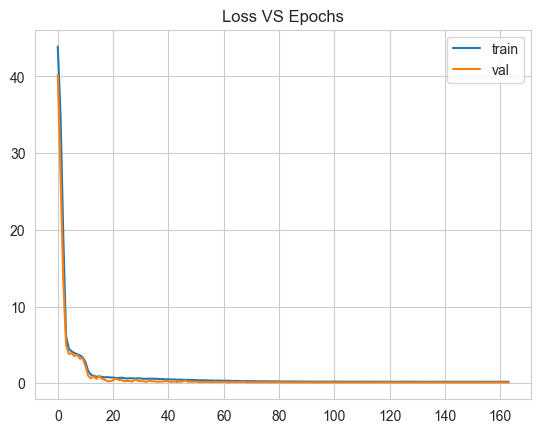

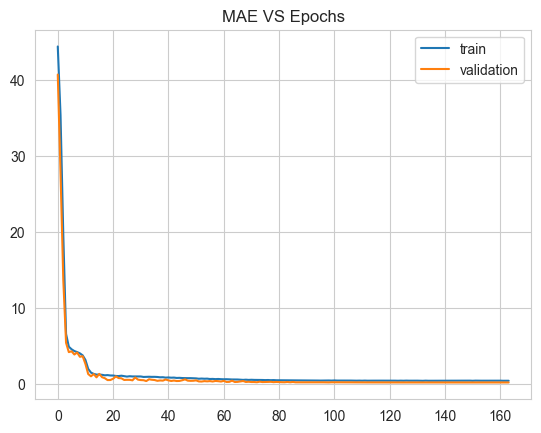

In [790]:
plt.figure()
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="val")
plt.legend()
plt.title("Loss VS Epochs")
plt.show()

plt.figure()
plt.plot(epochs, mae, label="train")
plt.plot(epochs, val_mae, label="validation")
plt.legend()
plt.title("MAE VS Epochs")
plt.show()

In [792]:
# Saving the best model.
model.save("best_model_reg.h5")

In [794]:
# Loading best model.
final_model = load_model('best_model_reg.h5')

In [795]:
val_loss, val_mae = final_model.evaluate(X_test_val_scaled, y_test_val)
print(f'Best Model Validation MAE: {val_mae:.4f}')

946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 0.1088 - mean_absolute_error: 0.2356
Best Model Validation MAE: 0.2287


In [796]:
loss = final_model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Test loss: {loss[0]:.4f}")

1182/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 0.1100 - mean_absolute_error: 0.2375
Test loss: 0.1058


In [797]:
predictions = final_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

1182/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
Mean Absolute Error: 0.23263386439091627
R² Score: 0.983696963524563


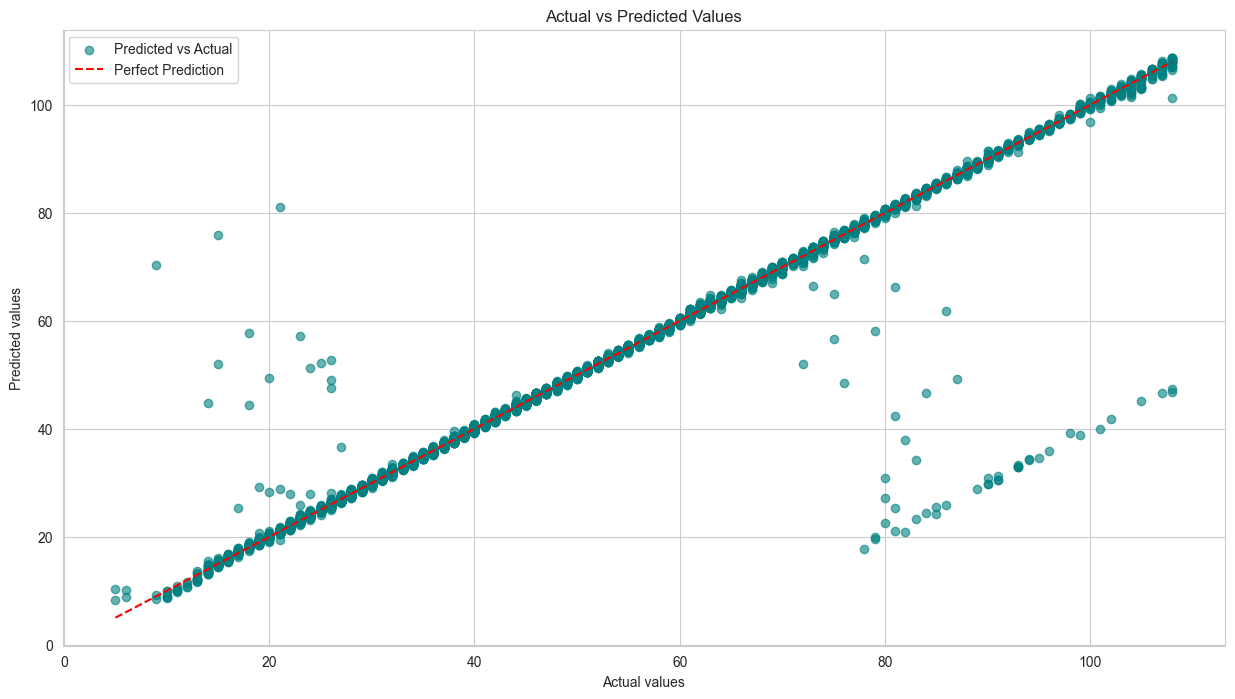

In [798]:
plt.figure(figsize=(15, 8))
plt.scatter(y_test, predictions, alpha=0.6, c='teal', label='Predicted vs Actual')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

#### The NN model demonstrates strong predictive performance, with a low Mean Absolute Error (MAE) of 0.2326 on the test set. The high R² score of 0.9837 indicates that the model explains 98.37% of the variance in the target variable. The model also generalizes well, as the validation and test MAE are closely aligned. Given its complexity, the model benefits from advanced techniques like learning rate scheduling, early stopping, and batch normalization, contributing to its robust performance.

#### XGBoost

In [769]:
# Comparing performance with XGBoost Regressor.

model_XGBR = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=10,
    random_state=42
)

model_XGBR.fit(X_train, y_train)
model_XGBR_predictions = model_XGBR.predict(X_test)

In [771]:
mae_XGBR = mean_absolute_error(y_test, model_XGBR_predictions)
r2_XGBR = r2_score(y_test, model_XGBR_predictions)

print(f"Mean Absolute Error: {mae_XGBR}")
print(f"R² Score: {r2_XGBR}")

Mean Absolute Error: 0.8674931281775087
R² Score: 0.9814193907116554


#### XGBoost also performs well, with an R² score of 0.9814, showing its effectiveness in capturing the data patterns. However, its MAE of 0.8675 is significantly higher than the NN model's, suggesting that while the overall fit is strong, the individual predictions are less accurate. XGBoost's lower MAE compared to Linear Regression indicates that it captures non-linear relationships better, but it still lags behind the NN model.

In [773]:
# Comparing performance with Linear Regression.

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [774]:
y_lr_pred = lr_model.predict(X_test_scaled)

In [775]:
mae_lr = mean_absolute_error(y_test, y_lr_pred)
r2_lr = r2_score(y_test, y_lr_pred)

print(f"Linear Regression Performance:")
print(f"MAE: {mae_lr:.4f}")
print(f"R² Score: {r2_lr:.4f}")

Linear Regression Performance:
MAE: 1.0256
R² Score: 0.9951


#### Linear Regression achieves the highest R² score of 0.9951, indicating an excellent overall fit to the data. However, the MAE of 1.0256 is the highest among all models, pointing to larger prediction errors on individual samples. This discrepancy suggests that while the model aligns well with the broad trends in the data, it struggles with precision at the granular level. This could be due to its inability to capture complex, non-linear relationships in the data.

#### Overall Comparison
1. #### The Neural Network model strikes a good balance between precision and generalization, making it the most reliable choice among the three.
2. #### XGBoost offers a good compromise between complexity and performance but does not match the accuracy of the NN model.
3. #### While Linear Regression fits the data well overall (high R²), its higher MAE indicates less reliable individual predictions, suggesting it might be overfitting or struggling with non-linearity in the data.